## **Fraud Detection in Python**
A typical organization loses an estimated 5% of its yearly revenue to fraud. In this course, learn to fight fraud by using data. Apply supervised learning algorithms to detect fraudulent behavior based upon past fraud, and use unsupervised learning methods to discover new types of fraud activities. 

Fraudulent transactions are rare compared to the norm.  As such, learn to properly classify imbalanced datasets.

This notebook technical and theoretical insights and demonstrates how to implement fraud detection models. Finally, get tips and advice from real-life experience to help prevent common mistakes in fraud analytics.

**Imports**

In [1]:
import warnings

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint as pp
import csv
from pathlib import Path
import seaborn as sns

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    r2_score,
    classification_report,
    confusion_matrix,
    accuracy_score,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score,
)
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

**Pandas Configuration Options**

In [3]:
pd.set_option("display.max_columns", 700)
pd.set_option("display.max_rows", 400)
pd.set_option("display.min_rows", 10)
pd.set_option("display.expand_frame_repr", True)

**Data Files Location**

* Most data files for the exercises can be found on the [this site](https://www.datacamp.com/courses/fraud-detection-in-python):
    * [Chapter 1](https://assets.datacamp.com/production/repositories/2162/datasets/cc3a36b722c0806e4a7df2634e345975a0724958/chapter_1.zip)
    * [Chapter 2](https://assets.datacamp.com/production/repositories/2162/datasets/4fb6199be9b89626dcd6b36c235cbf60cf4c1631/chapter_2.zip)

**Data File Objects**

In [4]:
data = Path.cwd() / "data"

ch1 = data / "chapter_1"
cc1_file = ch1 / "creditcard_sampledata.csv"
cc3_file = ch1 / "creditcard_sampledata_3.csv"

ch2 = data / "chapter_2"
cc2_file = ch2 / "creditcard_sampledata_2.csv"

# Introduction and preparing your data

Learn about the typical challenges associated with fraud detection. Learn how to resample data in a smart way, and tackle problems with imbalanced data.

## Introduction to fraud detection

* Types:
    * Insurance
    * Credit card
    * Identity theft
    * Money laundering
    * Tax evasion
    * Healthcare
    * Product warranty
* e-commerce businesses must continuously assess the legitimacy of client transactions
* Detecting fraud is challenging:
    * Uncommon; < 0.01% of transactions
    * Attempts are made to conceal fraud
    * Behavior evolves
    * Fraudulent activities perpetrated by networks - organized crime
* Fraud detection requires training an algorithm to identify concealed observations from any normal observations
* Fraud analytics teams:
    * Often use rules based systems, based on manually set thresholds and experience
    * Check the news
    * Receive external lists of fraudulent accounts and names
        * suspicious names or track an external hit list from police to reference check against the client base
    * Sometimes use machine learning algorithms to detect fraud or suspicious behavior
        * Existing sources can be used as inputs into the ML model
        * Verify the veracity of rules based labels

### Checking the fraud to non-fraud ratio

In this chapter, you will work on `creditcard_sampledata.csv`, a dataset containing credit card transactions data. Fraud occurrences are fortunately an **extreme minority** in these transactions.

However, Machine Learning algorithms usually work best when the different classes contained in the dataset are more or less equally present. If there are few cases of fraud, then there's little data to learn how to identify them. This is known as **class imbalance**, and it's one of the main challenges of fraud detection.

Let's explore this dataset, and observe this class imbalance problem.

**Instructions**

* `import pandas as pd`, read the credit card data in and assign it to `df`. This has been done for you.
* Use `.info()` to print information about `df`.
* Use `.value_counts()` to get the count of fraudulent and non-fraudulent transactions in the `'Class'` column. Assign the result to `occ`.
* Get the ratio of fraudulent transactions over the total number of transactions in the dataset.

In [5]:
df = pd.read_csv(cc3_file)

#### Explore the features available in your dataframe

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5050 entries, 0 to 5049
Data columns (total 31 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  5050 non-null   int64  
 1   V1          5050 non-null   float64
 2   V2          5050 non-null   float64
 3   V3          5050 non-null   float64
 4   V4          5050 non-null   float64
 5   V5          5050 non-null   float64
 6   V6          5050 non-null   float64
 7   V7          5050 non-null   float64
 8   V8          5050 non-null   float64
 9   V9          5050 non-null   float64
 10  V10         5050 non-null   float64
 11  V11         5050 non-null   float64
 12  V12         5050 non-null   float64
 13  V13         5050 non-null   float64
 14  V14         5050 non-null   float64
 15  V15         5050 non-null   float64
 16  V16         5050 non-null   float64
 17  V17         5050 non-null   float64
 18  V18         5050 non-null   float64
 19  V19         5050 non-null  

In [7]:
df.head()

,Unnamed: 0,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,258647,1.725265,-1.337256,-1.012687,-0.361656,-1.431611,-1.098681,-0.842274,-0.026594,-0.032409,0.215113,1.618952,-0.654046,-1.442665,-1.546538,-0.230008,1.785539,1.419793,0.071666,0.233031,0.275911,0.414524,0.793434,0.028887,0.419421,-0.367529,-0.155634,-0.015768,0.010790,189.00,0
1,69263,0.683254,-1.681875,0.533349,-0.326064,-1.455603,0.101832,-0.520590,0.114036,-0.601760,0.444011,1.521570,0.499202,-0.127849,-0.237253,-0.752351,0.667190,0.724785,-1.736615,0.702088,0.638186,0.116898,-0.304605,-0.125547,0.244848,0.069163,-0.460712,-0.017068,0.063542,315.17,0
2,96552,1.067973,-0.656667,1.029738,0.253899,-1.172715,0.073232,-0.745771,0.249803,1.383057,-0.483771,-0.782780,0.005242,-1.273288,-0.269260,0.091287,-0.347973,0.495328,-0.925949,0.099138,-0.083859,-0.189315,-0.426743,0.079539,0.129692,0.002778,0.970498,-0.035056,0.017313,59.98,0
3,281898,0.119513,0.729275,-1.678879,-1.551408,3.128914,3.210632,0.356276,0.920374,-0.160589,-0.801748,0.137341,-0.156740,-0.429388,-0.752392,0.155272,0.215068,0.352222,-0.376168,-0.398920,0.043715,-0.335825,-0.906171,0.108350,0.593062,-0.424303,0.164201,0.245881,0.071029,0.89,0
4,86917,1.271253,0.275694,0.159568,1.003096,-0.128535,-0.608730,0.088777,-0.145336,0.156047,0.022707,-0.963306,-0.228074,-0.324933,0.390609,1.065923,0.285930,-0.627072,0.170175,-0.215912,-0.147394,0.031958,0.123503,-0.174528,-0.147535,0.735909,-0.262270,0.015577,0.015955,6.53,0


In [8]:
# Count the occurrences of fraud and no fraud and print them
occ = df["Class"].value_counts()
occ

0    5000
1      50
Name: Class, dtype: int64

In [9]:
# Print the ratio of fraud cases
ratio_cases = occ / len(df.index)
print(
    f"Ratio of fraudulent cases: {ratio_cases[1]}\nRatio of non-fraudulent cases: {ratio_cases[0]}"
)

Ratio of fraudulent cases: 0.009900990099009901
Ratio of non-fraudulent cases: 0.9900990099009901


**The ratio of fraudulent transactions is very low. This is a case of class imbalance problem, and you're going to learn how to deal with this in the next exercises.**

### Data visualization

From the previous section we figured out that the ratio of fraud to non-fraud observations is very low. You can do something about that, for example by **re-sampling** our data, which is explained in the next video.

In this section, you'll look at the data and **visualize the fraud to non-fraud ratio**. It is always a good starting point in your fraud analysis, to look at your data first, before you make any changes to it.

Moreover, when talking to your colleagues, a picture often makes it very clear that we're dealing with heavily imbalanced data. Let's create a plot to visualize the ratio fraud to non-fraud data points on the dataset `df`.

The function `prep_data()` is already loaded in your workspace, as well as `matplotlib.pyplot as plt`.

**Instructions**

* Define the `plot_data(X, y)` function, that will nicely plot the given feature set `X` with labels `y` in a scatter plot. This has been done for you.
* Use the function `prep_data()` on your dataset `df` to create feature set `X` and labels `y`.
* Run the function `plot_data()` on your newly obtained `X` and `y` to visualize your results.

#### def prep_data

In [10]:
def prep_data(df: pd.DataFrame) -> (np.ndarray, np.ndarray):
    """
    Convert the DataFrame into two variable
    X: data columns (V1 - V28)
    y: lable column
    """
    X = df.iloc[:, 2:30].values
    y = df.Class.values
    return X, y

#### def plot_data

In [11]:
# Define a function to create a scatter plot of our data and labels
def plot_data(X: np.ndarray, y: np.ndarray):
    plt.scatter(X[y == 0, 0], X[y == 0, 1], label="Class #0", alpha=0.5, linewidth=0.15)
    plt.scatter(
        X[y == 1, 0], X[y == 1, 1], label="Class #1", alpha=0.5, linewidth=0.15, c="r"
    )
    plt.legend()
    return plt.show()

In [12]:
# Create X and y from the prep_data function
X, y = prep_data(df)

In [13]:
X.shape

(5050, 28)

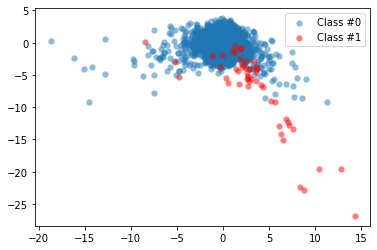

In [14]:
# Plot our data by running our plot data function on X and y
plot_data(X, y)

**By visualizing the data, you can immediately see how our fraud cases are scattered over our data, and how few cases we have. A picture often makes the imbalance problem clear. In the next exercises we'll visually explore how to improve our fraud to non-fraud balance.**

#### Reproduced using the DataFrame

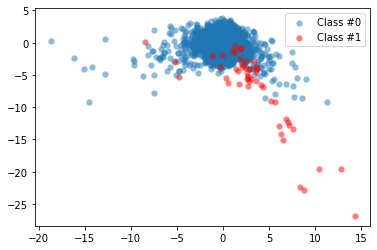

In [15]:
plt.scatter(
    df.V2[df.Class == 0],
    df.V3[df.Class == 0],
    label="Class #0",
    alpha=0.5,
    linewidth=0.15,
)
plt.scatter(
    df.V2[df.Class == 1],
    df.V3[df.Class == 1],
    label="Class #1",
    alpha=0.5,
    linewidth=0.15,
    c="r",
)
plt.legend()
plt.show()

## Increase successful detections with data resampling

* resampling can help model performance in cases of imbalanced data sets

#### Undersampling

* ![undersampling](https://raw.githubusercontent.com/trenton3983/DataCamp/master/Images/fraud_detection/undersampling.JPG)
* Undersampling the majority class (non-fraud cases)
    * Straightforward method to adjust imbalanced data
    * Take random draws from the non-fraud observations, to match the occurences of fraud observations (as shown in the picture)

#### Oversampling

* ![oversampling](https://raw.githubusercontent.com/trenton3983/DataCamp/master/Images/fraud_detection/oversampling.JPG)
* Oversampling the minority class (fraud cases)
    * Take random draws from the fraud cases and copy those observations to increase the amount of fraud samples
* Both methods lead to having a balance between fraud and non-fraud cases
* Drawbacks
    * with random undersampling, a lot of information is thrown away
    * with oversampling, the model will be trained on a lot of duplicates

#### Implement resampling methods using Python imblean module

* compatible with scikit-learn

```python
from imblearn.over_sampling import RandomOverSampler

method = RandomOverSampler()
X_resampled, y_resampled =  method.fit_sample(X, y)

compare_plots(X_resampled, y_resampled, X, y)
```

![oversampling plot](https://raw.githubusercontent.com/trenton3983/DataCamp/master/Images/fraud_detection/oversampling_plot.JPG)
* The darker blue points reflect there are more identical data

#### SMOTE

* ![smote](https://raw.githubusercontent.com/trenton3983/DataCamp/master/Images/fraud_detection/smote.JPG)
* Synthetic minority Oversampling Technique (SMOTE)
    * [Resampling strategies for Imbalanced Data Sets](https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets)
    * Another way of adjusting the imbalance by oversampling minority observations
    * SMOTE uses characteristics of nearest neighbors of fraud cases to create new synthetic fraud cases
        * avoids duplicating observations

#### Determining the best resampling method is situational

* Random Undersampling (RUS):
    * If there is a lot of data and many minority cases, then undersampling may be computationally more convenient
        * In most cases, throwing away data is not desirable
* Random Oversampling (ROS):
    * Straightforward
    * Training the model on many duplicates
* SMOTE:
    * more sophisticated
    * realistic data set
    * training on synthetic data
    * only works well if the minority case features are similar
        * **if fraud is spread through the data and not distinct, using nearest neighbors to create more fraud cases, introduces noise into the data, as the nearest neighbors might not be fraud cases**

#### When to use resmapling methods

* Use resampling methods on the training set, not on the test set
* The goal is to produce a better model by providing balanced data
    * The goal is not to predict the synthetic samples
* Test data should be free of duplicates and synthetic data
* Only test the model on real data
    * First, spit the data into train and test sets
    
```python
# Define resampling method and split into train and test
method = SMOTE(kind='borderline1')
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)

# Apply resampling to the training data only
X_resampled, y_resampled = method.fit_sample(X_train, y_train)

# Continue fitting the model and obtain predictions
model = LogisticRegression()
model.fit(X_resampled, y_resampled)

# Get model performance metrics
predicted = model.predict(X_test)
print(classification_report(y_test, predicted))
```

### Resampling methods for imbalanced data

Which of these methods takes a random subsample of your majority class to account for class "imbalancedness"?

**Possible Answers**

* ~~Random Over Sampling (ROS)~~
* **Random Under Sampling (RUS)**
* ~~Synthetic Minority Over-sampling Technique (SMOTE)~~
* ~~None of the above~~

**By using ROS and SMOTE you add more examples to the minority class. RUS adjusts the balance of your data by reducing the majority class.**

### Applying Synthetic Minority Oversampling Technique (SMOTE)

In this section, you're going to re-balance our data using the **Synthetic Minority Over-sampling Technique** (SMOTE). Unlike ROS, SMOTE does not create exact copies of observations, but **creates new, synthetic, samples** that are quite similar to the existing observations in the minority class. SMOTE is therefore slightly more sophisticated than just copying observations, so let's apply SMOTE to our credit card data. The dataset `df` is available and the packages you need for SMOTE are imported. In the following section, you'll visualize the result and compare it to the original data, such that you can see the effect of applying SMOTE very clearly.

**Instructions**

* Use the `prep_data` function on `df` to create features `X` and labels `y`.
* Define the resampling method as SMOTE of the regular kind, under the variable `method`.
* Use `.fit_sample()` on the original `X` and `y` to obtain newly resampled data.
* Plot the resampled data using the `plot_data()` function.

In [16]:
# Run the prep_data function
X, y = prep_data(df)

In [17]:
print(f"X shape: {X.shape}\ny shape: {y.shape}")

X shape: (5050, 28)
y shape: (5050,)


In [18]:
# Define the resampling method
method = SMOTE()

In [19]:
# Create the resampled feature set
X_resampled, y_resampled = method.fit_resample(X, y)

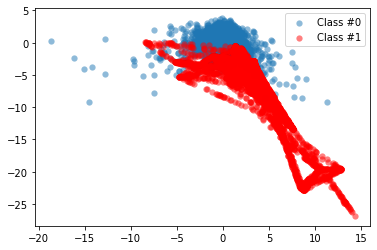

In [20]:
# Plot the resampled data
plot_data(X_resampled, y_resampled)

In [21]:
print(f"X_resampled shape: {X_resampled.shape}\ny_resampled shape: {y_resampled.shape}")

X_resampled shape: (10000, 28)
y_resampled shape: (10000,)


**The minority class is now much more prominently visible in our data. To see the results of SMOTE even better, we'll compare it to the original data in the next section.**

### Compare SMOTE to original data

In the last section, you saw that using SMOTE suddenly gives us more observations of the minority class. Let's compare those results to our original data, to get a good feeling for what has actually happened. Let's have a look at the value counts again of our old and new data, and let's plot the two scatter plots of the data side by side. You'll use the function compare_plot() for that that, which takes the following arguments: `X`, `y`, `X_resampled`, `y_resampled`, `method=''`. The function plots your original data in a scatter plot, along with the resampled side by side.

**Instructions**

* Print the value counts of our original labels, `y`. Be mindful that `y` is currently a Numpy array, so in order to use value counts, we'll assign `y` back as a pandas Series object.
* Repeat the step and print the value counts on `y_resampled`. This shows you how the balance between the two classes has changed with SMOTE.
* Use the `compare_plot()` function called on our original data as well our resampled data to see the scatterplots side by side.

In [22]:
pd.value_counts(pd.Series(y))

0    5000
1      50
dtype: int64

In [23]:
pd.value_counts(pd.Series(y_resampled))

0    5000
1    5000
dtype: int64

#### def compare_plot

In [24]:
def compare_plot(
    X: np.ndarray,
    y: np.ndarray,
    X_resampled: np.ndarray,
    y_resampled: np.ndarray,
    method: str,
):
    plt.subplot(1, 2, 1)
    plt.scatter(X[y == 0, 0], X[y == 0, 1], label="Class #0", alpha=0.5, linewidth=0.15)
    plt.scatter(
        X[y == 1, 0], X[y == 1, 1], label="Class #1", alpha=0.5, linewidth=0.15, c="r"
    )
    plt.title("Original Set")
    plt.subplot(1, 2, 2)
    plt.scatter(
        X_resampled[y_resampled == 0, 0],
        X_resampled[y_resampled == 0, 1],
        label="Class #0",
        alpha=0.5,
        linewidth=0.15,
    )
    plt.scatter(
        X_resampled[y_resampled == 1, 0],
        X_resampled[y_resampled == 1, 1],
        label="Class #1",
        alpha=0.5,
        linewidth=0.15,
        c="r",
    )
    plt.title(method)
    plt.legend()
    plt.show()

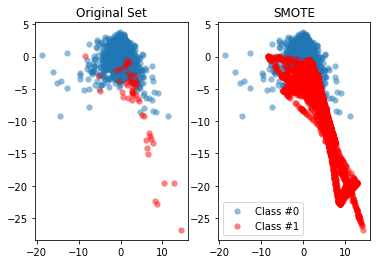

In [25]:
compare_plot(X, y, X_resampled, y_resampled, method="SMOTE")

**It should by now be clear that SMOTE has balanced our data completely, and that the minority class is now equal in size to the majority class. Visualizing the data shows the effect on the data very clearly. The next section will demonstrate multiple ways to implement SMOTE and that each method will have a slightly different effect.**

## Fraud detection algorithms in action

#### Rules Based Systems

* ![rules based](https://raw.githubusercontent.com/trenton3983/DataCamp/master/Images/fraud_detection/rules_based.JPG)
* Might block transactions from risky zip codes
* Block transactions from cards used too frequently (e.g. last 30 minutes)
* Can catch fraud, but also generates false alarms (false positive)
* Limitations:
    * Fixed threshold per rule and it's difficult to determine the threshold; they don't adapt over time
    * Limited to yes / no outcomes, whereas ML yields a probability
        * probability allows for fine-tuning the outcomes (i.e. rate of occurences of false positives and false negatives)
    * Fails to capture interaction between features
        * Ex. Size of the transaction only matters in combination to the frequency

#### ML Based Systems

* Adapt to the data, thus can change over time
* Uses all the data combined, rather than a threshold per feature
* Produces a probability, rather than a binary score
* Typically have better performance and can be combined with rules

In [26]:
# Step 1: split the features and labels into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [27]:
# Step 2: Define which model to use
model = LinearRegression()

In [28]:
# Step 3: Fit the model to the training data
model.fit(X_train, y_train)

LinearRegression()

In [29]:
# Step 4: Obtain model predictions from the test data
y_predicted = model.predict(X_test)

In [30]:
# Step 5: Compare y_test to predictions and obtain performance metrics (r^2 score)
r2_score(y_test, y_predicted)

0.687668860629139

### Exploring the traditional method of fraud detection

In this section, you're going to try finding fraud cases in our credit card dataset the *"old way"*. First you'll define threshold values using common statistics, to split fraud and non-fraud. Then, use those thresholds on your features to detect fraud. This is common practice within fraud analytics teams.

Statistical thresholds are often determined by looking at the **mean** values of observations. Let's start this section by checking whether feature **means differ between fraud and non-fraud cases**. Then, you'll use that information to create common sense thresholds. Finally, you'll check how well this performs in fraud detection.

`pandas` has already been imported as `pd`.

**Instructions**

* Use `groupby()` to group `df` on `Class` and obtain the mean of the features.
* Create the condition `V1` smaller than -3, and `V3` smaller than -5 as a condition to flag fraud cases.
* As a measure of performance, use the `crosstab` function from `pandas` to compare our flagged fraud cases to actual fraud cases.

In [31]:
df.drop(["Unnamed: 0"], axis=1, inplace=True)

In [32]:
df.groupby("Class").mean()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
Class,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.035030,0.011553,0.037444,-0.045760,-0.013825,-0.030885,0.014315,-0.022432,-0.002227,0.001667,-0.004511,0.017434,0.004204,0.006542,-0.026640,0.001190,0.004481,-0.010892,-0.016554,-0.002896,-0.010583,-0.010206,-0.003305,-0.000918,-0.002613,-0.004651,-0.009584,0.002414,85.843714
1,-4.985211,3.321539,-7.293909,4.827952,-3.326587,-1.591882,-5.776541,1.395058,-2.537728,-5.917934,4.020563,-7.032865,-0.104179,-7.100399,-0.120265,-4.658854,-7.589219,-2.650436,0.894255,0.194580,0.703182,0.069065,-0.088374,-0.029425,-0.073336,-0.023377,0.380072,0.009304,113.469000


In [33]:
df["flag_as_fraud"] = np.where(np.logical_and(df.V1 < -3, df.V3 < -5), 1, 0)

In [34]:
pd.crosstab(
    df.Class, df.flag_as_fraud, rownames=["Actual Fraud"], colnames=["Flagged Fraud"]
)

Flagged Fraud,0,1
Actual Fraud,,
0,4984,16
1,28,22


**With this rule, 22 out of 50 fraud cases are detected, 28 are not detected, and 16 false positives are identified.**

### Using ML classification to catch fraud

In this section, you'll see what happens when you use a simple machine learning model on our credit card data instead.

Do you think you can beat those results? Remember, you've predicted *22 out of 50* fraud cases, and had *16 false positives*.

So with that in mind, let's implement a **Logistic Regression** model. If you have taken the class on supervised learning in Python, you should be familiar with this model. If not, you might want to refresh that at this point. But don't worry, you'll be guided through the structure of the machine learning model.

The `X` and `y` variables are available in your workspace.

**Instructions**

* Split `X` and `y` into training and test data, keeping 30% of the data for testing.
* Fit your model to your training data.
* Obtain the model predicted labels by running `model.predict` on `X_test`.
* Obtain a classification comparing `y_test` with `predicted`, and use the given confusion matrix to check your results.

In [35]:
# Create the training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [36]:
# Fit a logistic regression model to our data
model = LogisticRegression(solver="liblinear")
model.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

In [37]:
# Obtain model predictions
predicted = model.predict(X_test)

In [38]:
# Print the classifcation report and confusion matrix
print("Classification report:\n", classification_report(y_test, predicted))
conf_mat = confusion_matrix(y_true=y_test, y_pred=predicted)
print("Confusion matrix:\n", conf_mat)

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1505
           1       0.89      0.80      0.84        10

    accuracy                           1.00      1515
   macro avg       0.94      0.90      0.92      1515
weighted avg       1.00      1.00      1.00      1515

Confusion matrix:
 [[1504    1]
 [   2    8]]


**Do you think these results are better than the rules based model? We are getting far fewer false positives, so that's an improvement. Also, we're catching a higher percentage of fraud cases, so that is also better than before. Do you understand why we have fewer observations to look at in the confusion matrix? Remember we are using only our test data to calculate the model results on. We're comparing the crosstab on the full dataset from the last section, with a confusion matrix of only 30% of the total dataset, so that's where that difference comes from. In the next section, we'll dive deeper into understanding these model performance metrics. Let's now explore whether we can improve the prediction results even further with resampling methods.**

### Logistic regression with SMOTE

In this section, you're going to take the Logistic Regression model from the previous section, and combine that with a **SMOTE resampling method**. We'll show you how to do that efficiently by using a pipeline that combines the resampling method with the model in one go. First, you need to define the pipeline that you're going to use.

**Instructions**

* Import the `Pipeline` module from `imblearn`, this has been done for you.
* Then define what you want to put into the pipeline, assign the `SMOTE` method with `borderline2` to `resampling`, and assign `LogisticRegression()` to the `model`.
* Combine two steps in the `Pipeline()` function. You need to state you want to combine `resampling` with the `model` in the respective place in the argument. I show you how to do this.

In [39]:
# Define which resampling method and which ML model to use in the pipeline
# resampling = SMOTE(kind='borderline2')  # has been changed to BorderlineSMOTE
resampling = BorderlineSMOTE()
model = LogisticRegression(solver="liblinear")

In [40]:
pipeline = Pipeline([("SMOTE", resampling), ("Logistic Regression", model)])

### Pipelining

Now that you have our pipeline defined, aka **combining a logistic regression with a SMOTE method**, let's run it on the data. You can treat the pipeline as if it were a **single machine learning model**. Our data X and y are already defined, and the pipeline is defined in the previous section. Are you curious to find out what the model results are? Let's give it a try!

**Instructions**

* Split the data 'X'and 'y' into the training and test set. Set aside 30% of the data for a test set, and set the `random_state` to zero.
* Fit your pipeline onto your training data and obtain the predictions by running the `pipeline.predict()` function on our `X_test` dataset.

In [41]:
# Split your data X and y, into a training and a test set and fit the pipeline onto the training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [42]:
X_train.shape, X_test.shape

((3535, 28), (1515, 28))

In [43]:
pipeline.fit(X_train, y_train)
predicted = pipeline.predict(X_test)

In [44]:
# Obtain the results from the classification report and confusion matrix
print("Classifcation report:\n", classification_report(y_test, predicted))
conf_mat = confusion_matrix(y_true=y_test, y_pred=predicted)
print("Confusion matrix:\n", conf_mat)

Classifcation report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1505
           1       0.71      1.00      0.83        10

    accuracy                           1.00      1515
   macro avg       0.86      1.00      0.92      1515
weighted avg       1.00      1.00      1.00      1515

Confusion matrix:
 [[1501    4]
 [   0   10]]


**As you can see, the SMOTE slightly improves our results. We now manage to find all cases of fraud, but we have a slightly higher number of false positives, albeit only 4 cases. Remember, resampling doesn't necessarily lead to better results. When the fraud cases are very spread and scattered over the data, using SMOTE can introduce a bit of bias. Nearest neighbors aren't necessarily also fraud cases, so the synthetic samples might 'confuse' the model slightly. In the next sections, we'll learn how to also adjust our machine learning models to better detect the minority fraud cases.**

# Fraud detection using labeled data

Learn how to flag fraudulent transactions with supervised learning. Use classifiers, adjust and compare them to find the most efficient fraud detection model.

## Review classification methods

* Classification:
    * The problem of identifying to which class a new observation belongs, on the basis of a training set of data containing observations whose class is known
    * Goal: use known fraud cases to train a model to recognize new cases
    * Classes are sometimes called targets, labels or categories
    * Spam detection in email service providers can be identified as a classification problem
        * Binary classification since there are only 2 classes, spam and not spam
    * Fraud detection is also a binary classification prpoblem
    * Patient diagnosis
    * Classification problems normall have categorical output like yes/no, 1/0 or True/False
    * Variable to predict: $$y\in0,1$$
        * 0: negative calss ('majority' normal cases)
        * 1: positive class ('minority' fraud cases)

#### Logistic Regression

* Logistic Regression is one of the most used ML algorithms in binary classification
* ![logistic regression](https://raw.githubusercontent.com/trenton3983/DataCamp/master/Images/fraud_detection/logistic_regression.JPG)
* Can be adjusted reasonably well to work on imbalanced data...useful for fraud detection

#### Neural Network

* ![neural network](https://raw.githubusercontent.com/trenton3983/DataCamp/master/Images/fraud_detection/neural_network.JPG)
* Can be used as classifiers for fraud detection
* Capable of fitting highly non-linear models to the data
* More complex to implement than other classifiers - not demonstrated here

#### Decision Trees

* ![decision tree](https://raw.githubusercontent.com/trenton3983/DataCamp/master/Images/fraud_detection/decision_tree.JPG)
* Commonly used for fraud detection
* Transparent results, easily interpreted by analysts
* Decision trees are prone to overfit the data

#### Random Forests

* ![random forest](https://raw.githubusercontent.com/trenton3983/DataCamp/master/Images/fraud_detection/random_forest.JPG)
* **Random Forests are a more robust option than a single decision tree**
    * Construct a multitude of decision trees when training the model and outputting the class that is the mode or mean predicted class of the individual trees
    * A random forest consists of a collection of trees on a random subset of features
    * Final predictions are the combined results of those trees
    * Random forests can handle complex data and are not prone to overfit
    * They are interpretable by looking at feature importance, and can be adjusted to work well on highly imbalanced data
    * Their drawback is they're computationally complex
    * Very popular for fraud detection
    * A Random Forest model will be optimized in the sections
    
**Implementation:**

```python
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit(X_train, y_train)
predicted = model.predict(X_test)
print(f'Accuracy Score:\n{accuracy_score(y_test, predicted)}')
```

### Natural hit rate

In this section, you'll again use credit card transaction data. The features and labels are similar to the data in the previous section, and the **data is heavily imbalanced**. We've given you features `X` and labels `y` to work with already, which are both numpy arrays.

First you need to explore how prevalent fraud is in the dataset, to understand what the **"natural accuracy"** is, if we were to predict everything as non-fraud. It's is important to understand which level of "accuracy" you need to "beat" in order to get a **better prediction than by doing nothing**. In the following sections, you'll create our first random forest classifier for fraud detection. That will serve as the **"baseline"** model that you're going to try to improve in the upcoming sections.

**Instructions**

* Count the total number of observations by taking the length of your labels `y`.
* Count the non-fraud cases in our data by using list comprehension on `y`; remember `y` is a NumPy array so `.value_counts()` cannot be used in this case.
* Calculate the natural accuracy by dividing the non-fraud cases over the total observations.
* Print the percentage.

In [45]:
df2 = pd.read_csv(cc2_file)
df2.head()

,Unnamed: 0,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,221547,-1.191668,0.428409,1.640028,-1.848859,-0.870903,-0.204849,-0.385675,0.352793,-1.098301,-0.334597,-0.679089,-0.039671,1.372661,-0.732001,-0.344528,1.024751,0.380209,-1.087349,0.364507,0.051924,0.507173,1.292565,-0.467752,1.244887,0.697707,0.059375,-0.319964,-0.017444,27.44,0
1,184524,1.966614,-0.450087,-1.228586,0.142873,-0.150627,-0.543590,-0.076217,-0.108390,0.973310,-0.029903,0.279973,0.885685,-0.583912,0.322019,-1.065335,-0.340285,-0.385399,0.216554,0.675646,-0.190851,0.124055,0.564916,-0.039331,-0.283904,0.186400,0.192932,-0.039155,-0.071314,35.95,0
2,91201,1.528452,-1.296191,-0.890677,-2.504028,0.803202,3.350793,-1.633016,0.815350,-1.884692,1.465259,-0.188235,-0.976779,0.560550,-0.250847,0.936115,0.136409,-0.078251,0.355086,0.127756,-0.163982,-0.412088,-1.017485,0.129566,0.948048,0.287826,-0.396592,0.042997,0.025853,28.40,0
3,26115,-0.774614,1.100916,0.679080,1.034016,0.168633,0.874582,0.209454,0.770550,-0.558106,-0.165442,0.017562,0.285377,-0.818739,0.637991,-0.370124,-0.605148,0.275686,0.246362,1.331927,0.080978,0.011158,0.146017,-0.130401,-0.848815,0.005698,-0.183295,0.282940,0.123856,43.20,0
4,201292,-1.075860,1.361160,1.496972,2.242604,1.314751,0.272787,1.005246,0.132932,-1.558317,0.484216,-1.967998,-1.818338,-2.036184,0.346962,-1.161316,1.017093,-0.926787,0.183965,-2.102868,-0.354008,0.254485,0.530692,-0.651119,0.626389,1.040212,0.249501,-0.146745,0.029714,10.59,0


In [46]:
X, y = prep_data(df2)
print(f"X shape: {X.shape}\ny shape: {y.shape}")

X shape: (7300, 28)
y shape: (7300,)


In [47]:
X[0, :]

array([ 4.28408570e-01,  1.64002800e+00, -1.84885886e+00, -8.70902974e-01,
       -2.04848888e-01, -3.85675453e-01,  3.52792552e-01, -1.09830131e+00,
       -3.34596757e-01, -6.79088729e-01, -3.96709268e-02,  1.37266082e+00,
       -7.32000706e-01, -3.44528134e-01,  1.02475103e+00,  3.80208554e-01,
       -1.08734881e+00,  3.64507163e-01,  5.19236276e-02,  5.07173439e-01,
        1.29256539e+00, -4.67752261e-01,  1.24488683e+00,  6.97706854e-01,
        5.93750372e-02, -3.19964326e-01, -1.74444289e-02,  2.74400000e+01])

In [48]:
df2.Class.value_counts()

0    7000
1     300
Name: Class, dtype: int64

In [49]:
# Count the total number of observations from the length of y
total_obs = len(y)
total_obs

7300

In [50]:
# Count the total number of non-fraudulent observations
non_fraud = [i for i in y if i == 0]
count_non_fraud = non_fraud.count(0)
count_non_fraud

7000

In [51]:
percentage = count_non_fraud / total_obs * 100
print(f"{percentage:0.2f}%")

95.89%


This tells us that by doing nothing, we would be correct in 95.9% of the cases. So now you understand, that **if we get an accuracy of less than this number, our model does not actually add any value in predicting how many cases are correct.** Let's see how a random forest does in predicting fraud in our data.

### Random Forest Classifier - part 1

Let's now create a first **random forest classifier** for fraud detection. Hopefully you can do better than the baseline accuracy you've just calculated, which was roughly **96%**. This model will serve as the **"baseline" model** that you're going to try to improve in the upcoming sections. Let's start first with **splitting the data into a test and training set**, and **defining the Random Forest model**. The data available are features `X` and labels `y`.

**Instructions**

* Import the random forest classifier from `sklearn`.
* Split your features `X` and labels `y` into a training and test set. Set aside a test set of 30%.
* Assign the random forest classifier to `model` and keep `random_state` at 5. We need to set a random state here in order to be able to compare results across different models.

#### X_train, X_test, y_train, y_test

In [52]:
# Split your data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [53]:
# Define the model as the random forest
model = RandomForestClassifier(random_state=5, n_estimators=20)

### Random Forest Classifier - part 2

Let's see how our Random Forest model performs **without doing anything special to it**. The `model` from the previous section is available, and you've already split your data in `X_train, y_train, X_test, y_test`.

**Instructions 1/3**

* Fit the earlier defined `model` to our training data and obtain predictions by getting the model predictions on `X_test`.

In [54]:
# Fit the model to our training set
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=20, random_state=5)

In [55]:
# Obtain predictions from the test data
predicted = model.predict(X_test)

**Instructions 2/3**

* Obtain and print the accuracy score by comparing the actual labels `y_test` with our predicted labels `predicted`.

In [56]:
print(f"Accuracy Score:\n{accuracy_score(y_test, predicted):0.3f}")

Accuracy Score:
0.991


**Instructions 3/3**

What is a benefit of using Random Forests versus Decision Trees?

**Possible Answers**

* ~~Random Forests always have a higher accuracy than Decision Trees.~~
* **Random Forests do not tend to overfit, whereas Decision Trees do.**
* ~~Random Forests are computationally more efficient than Decision Trees.~~
* ~~You can obtain "feature importance" from Random Forest, which makes it more transparent.~~

**Random Forest prevents overfitting most of the time, by creating random subsets of the features and building smaller trees using these subsets. Afterwards, it combines the subtrees of subsamples of features, so it does not tend to overfit to your entire feature set the way "deep" Decisions Trees do.**

## Perfomance evaluation

* Performance metrics for fraud detection models
* There are other performace metrics that are more informative and reliable than accuracy

#### Accuracy

![accuracy](https://raw.githubusercontent.com/trenton3983/DataCamp/master/Images/fraud_detection/accuracy.JPG)
* Accuracy isn't a reliable performance metric when working with highly imbalanced data (such as fraud detection)
* By doing nothing, aka predicting everything is the majority class (right image), a higher accuracy is obtained than by trying to build a predictive model (left image)

#### Confusion Matrix

![advanced confusion matrix](https://raw.githubusercontent.com/trenton3983/DataCamp/master/Images/fraud_detection/confusion_matrix_advanced.JPG)
![confusion matrix](https://raw.githubusercontent.com/trenton3983/DataCamp/master/Images/fraud_detection/confusion_matrix.JPG)
* [Confusion Matrix](https://en.wikipedia.org/wiki/Confusion_matrix)
* False Positives (FP) / False Negatives (FN)
    * FN: predicts the person is not pregnant, but actually is
        * Cases of fraud not caught by the model
    * FP: predicts the person is pregnant, but actually is not
        * Cases of 'false alarm'
    * **the business case determines whether FN or FP cases are more important**
        * a credit card company might want to catch as much fraud as possible and reduce false negatives, as fraudulent transactions can be incredibly costly
            * a false alarm just means a transaction is blocked
        * an insurance company can't handle many false alarms, as it means getting a team of investigators involved for each positive prediction
        
* True Positives / True Negatives are the cases predicted correctly (e.g. fraud / non-fraud)

#### Precision Recall

* **Credit card company wants to optimize for recall**
* **Insurance company wants to optimize for precision**
* Precision:
    * $$Precision=\frac{\#\space True\space Positives}{\#\space True\space Positives+\#\space False\space Positives}$$
    * Fraction of actual fraud cases out of all predicted fraud cases
        * true positives relative to the sum of true positives and false positives
* Recall:
    * $$Recall=\frac{\#\space True\space Positives}{\#\space True\space Positives+\#\space False\space Negatives}$$
    * Fraction of predicted fraud cases out of all actual fraud cases
        * true positives relative to the sum of true positives and false negative
* Precision and recall are typically inversely related
    * As precision increases, recall falls and vice-versa
    * ![precision recall inverse relation](https://raw.githubusercontent.com/trenton3983/DataCamp/master/Images/fraud_detection/precision_recall_inverse.JPG)

#### F-Score

* Weighs both precision and recall into on measure

\begin{align}
F-measure = \frac{2\times{Precision}\times{Recall}}{Precision\times{Recall}} \\ 
\\
= \frac{2\times{TP}}{2\times{TP}+FP+FN}
\end{align}

* is a performance metric that takes into account a balance between Precision and Recall

#### Obtaining performance metrics from sklearn

```python
# import the methods
from sklearn.metrics import precision_recall_curve, average_precision_score

# Calculate average precision and the PR curve
average_precision = average_precision_score(y_test, predicted)

# Obtain precision and recall
precision, recall = precision_recall_curve(y_test, predicted)
```

#### Receiver Operating Characteristic (ROC) curve to compare algorithms

* Created by plotting the true positive rate against the false positive rate at various threshold settings
* ![roc curve](https://raw.githubusercontent.com/trenton3983/DataCamp/master/Images/fraud_detection/roc_curve.JPG)
* Useful for comparing performance of different algorithms

```python
# Obtain model probabilities
probs = model.predict_proba(X_test)

# Print ROC_AUC score using probabilities
print(metrics.roc_auc_score(y_test, probs[:, 1]))
```

#### Confusion matrix and classification report

```python
from sklearn.metrics import classification_report, confusion_matrix

# Obtain predictions
predicted = model.predict(X_test)

# Print classification report using predictions
print(classification_report(y_test, predicted))

# Print confusion matrix using predictions
print(confusion_matrix(y_test, predicted))
```

### Performance metrics for the RF model

In the previous sections you obtained an accuracy score for your random forest model. This time, we know **accuracy can be misleading** in the case of fraud detection. With highly imbalanced fraud data, **the AUROC curve is a more reliable performance metric**, used to compare different classifiers. Moreover, the *classification report* tells you about the precision and recall of your model, whilst the *confusion matrix* actually shows how many fraud cases you can predict correctly. So let's get these performance metrics.

You'll continue working on the same random forest model from the previous section. Your model, defined as `model = RandomForestClassifier(random_state=5)` has been fitted to your training data already, and `X_train, y_train, X_test, y_test` are available.

**Instructions**

* Import the classification report, confusion matrix and ROC score from `sklearn.metrics`.
* Get the binary predictions from your trained random forest `model`.
* Get the predicted probabilities by running the `predict_proba()` function.
* Obtain classification report and confusion matrix by comparing `y_test` with `predicted`.

In [57]:
# Obtain the predictions from our random forest model
predicted = model.predict(X_test)

In [58]:
# Predict probabilities
probs = model.predict_proba(X_test)

In [59]:
# Print the ROC curve, classification report and confusion matrix
print("ROC Score:")
print(roc_auc_score(y_test, probs[:, 1]))
print("\nClassification Report:")
print(classification_report(y_test, predicted))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, predicted))

ROC Score:
0.9419896444670147

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2099
           1       0.97      0.80      0.88        91

    accuracy                           0.99      2190
   macro avg       0.98      0.90      0.94      2190
weighted avg       0.99      0.99      0.99      2190


Confusion Matrix:
[[2097    2]
 [  18   73]]


**You have now obtained more meaningful performance metrics that tell us how well the model performs, given the highly imbalanced data that you're working with. The model predicts 75 cases of fraud, out of which 73 are actual fraud. You have only 2 false positives. This is really good, and as a result you have a very high precision score. You do however, miss 18 cases of actual fraud. Recall is therefore not as good as precision.**

### Plotting the Precision vs. Recall Curve

You can also plot a **Precision-Recall curve**, to investigate the trade-off between the two in your model. In this curve **Precision and Recall are inversely related**; as Precision increases, Recall falls and vice-versa. A balance between these two needs to be achieved in your model, otherwise you might end up with many false positives, or not enough actual fraud cases caught. To achieve this and to compare performance, the precision-recall curves come in handy.

Your Random Forest Classifier is available as `model`, and the predictions as `predicted`. You can simply obtain the average precision score and the PR curve from the sklearn package. The function `plot_pr_curve()` plots the results for you. Let's give it a try.

**Instructions 1/3**

* Calculate the average precision by running the function on the actual labels `y_test` and your predicted labels `predicted`.

In [60]:
# Calculate average precision and the PR curve
average_precision = average_precision_score(y_test, predicted)
average_precision

0.7890250388880526

**Instructions 2/3**

* Run the `precision_recall_curve()` function on the same arguments `y_test` and `predicted` and plot the curve.

In [61]:
# Obtain precision and recall
precision, recall, _ = precision_recall_curve(y_test, predicted)
print(f"Precision: {precision}\nRecall: {recall}")

Precision: [0.04155251 0.97333333 1.        ]
Recall: [1.        0.8021978 0.       ]


#### def plot_pr_curve

In [62]:
def plot_pr_curve(recall, precision, average_precision):
    """
    https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html
    """
    from inspect import signature

    plt.figure()
    step_kwargs = (
        {"step": "post"} if "step" in signature(plt.fill_between).parameters else {}
    )

    plt.step(recall, precision, color="b", alpha=0.2, where="post")
    plt.fill_between(recall, precision, alpha=0.2, color="b", **step_kwargs)

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.ylim([0.0, 1.0])
    plt.xlim([0.0, 1.0])
    plt.title(f"2-class Precision-Recall curve: AP={average_precision:0.2f}")
    return plt.show()

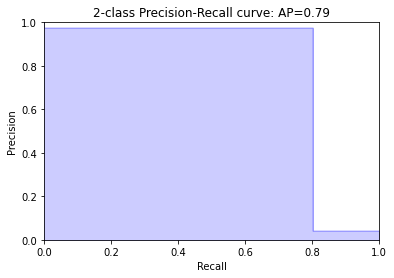

In [63]:
# Plot the recall precision tradeoff
plot_pr_curve(recall, precision, average_precision)

**Instructions 3/3**

What's the benefit of the performance metric ROC curve (AUROC) versus Precision and Recall?

**Possible Answers**

* **The AUROC answers the question: "How well can this classifier be expected to perform in general, at a variety of different baseline probabilities?" but precision and recall don't.**
* ~~The AUROC answers the question: "How meaningful is a positive result from my classifier given the baseline probabilities of my problem?" but precision and recall don't.~~
* ~~Precision and Recall are not informative when the data is imbalanced.~~
* ~~The AUROC curve allows you to visualize classifier performance and with Precision and Recall you cannot.~~

**The ROC curve plots the true positives vs. false positives, for a classifier, as its discrimination threshold is varied. Since, a random method describes a horizontal curve through the unit interval, it has an AUC of 0.5. Minimally, classifiers should perform better than this, and the extent to which they score higher than one another (meaning the area under the ROC curve is larger), they have better expected performance.**

## Adjusting the algorithm weights

* Adjust model parameter to optimize for fraud detection.
* When training a model, try different options and settings to get the best recall-precision trade-off
* sklearn has two simple options to tweak the model for heavily imbalanced data
    * `class_weight`:
        * `balanced` mode: `model = RandomForestClassifier(class_weight='balanced')`
            * uses the values of y to automatically adjust weights inversely proportional to class frequencies in the the input data
            * this option is available for other classifiers
                * `model = LogisticRegression(class_weight='balanced')`
                * `model = SVC(kernel='linear', class_weight='balanced', probability=True)`
        * `balanced_subsample` mode: `model = RandomForestClassifier(class_weight='balanced_subsample')`
            * is the same as the `balanced` option, except weights are calculated again at each iteration of growing a tree in a the random forest
            * this option is only applicable for the Random Forest model
        * manual input
            * adjust weights to any ratio, not just value counts relative to sample
            * `class_weight={0:1,1:4}`
            * this is a good option to slightly upsample the minority class

#### Hyperparameter tuning

* Random Forest takes many other options to optimize the model

```python
model = RandomForestClassifier(n_estimators=10, 
                               criterion=’gini’, 
                               max_depth=None, 
                               min_samples_split=2, 
                               min_samples_leaf=1, 
                               max_features=’auto’, 
                               n_jobs=-1, class_weight=None)
```

* the shape and size of the trees in a random forest are adjusted with **leaf size** and **tree depth**
* `n_estimators`: one of the most important setting is the number of trees in the forest
* `max_features`: the number of features considered for splitting at each leaf node
* `criterion`: change the way the data is split at each node (default is `gini` coefficient)

#### GridSearchCV for hyperparameter tuning

* [sklearn.model_selection.GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)
* `from sklearn.model_selection import GridSearchCV`
* `GridSearchCV evaluates all combinations of parameters defined in the parameter grid
* Random Forest Parameter Grid:

```python
# Create the parameter grid 
param_grid = {'max_depth': [80, 90, 100, 110],
              'max_features': [2, 3],
              'min_samples_leaf': [3, 4, 5],
              'min_samples_split': [8, 10, 12],
              'n_estimators': [100, 200, 300, 1000]}

# Define which model to use
model = RandomForestRegressor()

# Instantiate the grid search model
grid_search_model = GridSearchCV(estimator = model, 
                                 param_grid = param_grid, 
                                 cv = 5,
                                 n_jobs = -1, 
                                 scoring='f1')
```

* define the ML model to be used
* put the model into `GridSearchCV`
* pass in `param_grid`
* frequency of cross-validation
* define a scoring metric to evaluate the models
    * the default option is accuracy which isn't optimal for fraud detection
    * use `precision`, `recall` or `f1`

```python
# Fit the grid search to the data
grid_search_model.fit(X_train, y_train)

# Get the optimal parameters 
grid_search_model.best_params_

{'bootstrap': True,
 'max_depth': 80,
 'max_features': 3,
 'min_samples_leaf': 5,
 'min_samples_split': 12,
 'n_estimators': 100}
```

* once `GridSearchCV` and `model` are fit to the data, obtain the parameters belonging to the optimal model by using the `best_params_` attribute
* `GridSearchCV` is computationally heavy
    * Can require many hours, depending on the amount of data and number of parameters in the grid
    * __**Save the Results**__

```python
# Get the best_estimator results
grid_search.best_estimator_
grid_search.best_score_
```

* `best_score_`: mean cross-validated score of the `best_estimator_`, which depends on the `scoring` option

### Model adjustments

A simple way to adjust the random forest model to deal with highly imbalanced fraud data, is to use the **`class_weights` option** when defining the `sklearn` model. However, as you will see, it is a bit of a brute force mechanism and might not work for your very special case.

In this section you'll explore the ``weight = "balanced_subsample"`` mode the Random Forest model from the earlier section. You already have split your data in a training and test set, i.e `X_train`, `X_test`, `y_train`, `y_test` are available. The metrics function have already been imported.

**Instructions**

* Set the `class_weight` argument of your classifier to `balanced_subsample`.
* Fit your model to your training set.
* Obtain predictions and probabilities from X_test.
* Obtain the `roc_auc_score`, the classification report and confusion matrix.

In [64]:
# Define the model with balanced subsample
model = RandomForestClassifier(
    class_weight="balanced_subsample", random_state=5, n_estimators=100
)

# Fit your training model to your training set
model.fit(X_train, y_train)

# Obtain the predicted values and probabilities from the model
predicted = model.predict(X_test)
probs = model.predict_proba(X_test)

# Print the ROC curve, classification report and confusion matrix
print("ROC Score:")
print(roc_auc_score(y_test, probs[:, 1]))
print("\nClassification Report:")
print(classification_report(y_test, predicted))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, predicted))

ROC Score:
0.9750299724096771

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2099
           1       0.99      0.80      0.88        91

    accuracy                           0.99      2190
   macro avg       0.99      0.90      0.94      2190
weighted avg       0.99      0.99      0.99      2190


Confusion Matrix:
[[2098    1]
 [  18   73]]


**You can see that the model results don't improve drastically. We now have 1 less false positives, but still 18 of 18 false negatives, i.e. cases of fraud we are not catching. If we mostly care about catching fraud, and not so much about the false positives, this does actually not improve our model at all, albeit a simple option to try. In the next sections you'll see how to more smartly tweak your model to focus on reducing false negatives and catch more fraud.**

### Adjusting RF for fraud detection

In this section, you're going to dive into the options for the random forest classifier, as we'll **assign weights** and **tweak the shape** of the decision trees in the forest. You'll **define weights manually**, to be able to off-set that imbalance slightly. In our case we have 300 fraud to 7000 non-fraud cases, so by setting the weight ratio to 1:12, we get to a 1/3 fraud to 2/3 non-fraud ratio, which is good enough for training the model on.

The data in this section has already been split into training and test set, so you just need to focus on defining your model. You can then use the function `get_model_results()` as a short cut. This function fits the model to your training data, predicts and obtains performance metrics similar to the steps you did in the previous sections.

**Instructions**

* Change the `weight` option to set the ratio to 1 to 12 for the non-fraud and fraud cases, and set the split criterion to 'entropy'.
* Set the maximum depth to 10.
* Set the minimal samples in leaf nodes to 10.
* Set the number of trees to use in the model to 20.

#### def get_model_results

In [65]:
def get_model_results(
    X_train: np.ndarray,
    y_train: np.ndarray,
    X_test: np.ndarray,
    y_test: np.ndarray,
    model,
):
    """
    model: sklearn model (e.g. RandomForestClassifier)
    """
    # Fit your training model to your training set
    model.fit(X_train, y_train)

    # Obtain the predicted values and probabilities from the model
    predicted = model.predict(X_test)

    try:
        probs = model.predict_proba(X_test)
        print("ROC Score:")
        print(roc_auc_score(y_test, probs[:, 1]))
    except AttributeError:
        pass

    # Print the ROC curve, classification report and confusion matrix
    print("\nClassification Report:")
    print(classification_report(y_test, predicted))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, predicted))

In [66]:
# Change the model options
model = RandomForestClassifier(
    bootstrap=True,
    class_weight={0: 1, 1: 12},
    criterion="entropy",
    # Change depth of model
    max_depth=10,
    # Change the number of samples in leaf nodes
    min_samples_leaf=10,
    # Change the number of trees to use
    n_estimators=20,
    n_jobs=-1,
    random_state=5,
)

# Run the function get_model_results
get_model_results(X_train, y_train, X_test, y_test, model)

ROC Score:
0.9609651901219315

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2099
           1       0.97      0.85      0.91        91

    accuracy                           0.99      2190
   macro avg       0.98      0.92      0.95      2190
weighted avg       0.99      0.99      0.99      2190


Confusion Matrix:
[[2097    2]
 [  14   77]]


**By smartly defining more options in the model, you can obtain better predictions. You have effectively reduced the number of false negatives, i.e. you are catching more cases of fraud, whilst keeping the number of false positives low. In this section you've manually changed the options of the model. There is a smarter way of doing it, by using `GridSearchCV`, which you'll see in the next section!**

### Parameter optimization with GridSearchCV

In this section you're going to **tweak our model in a less "random" way**, but use `GridSearchCV` to do the work for you.

With `GridSearchCV` you can define **which performance metric to score** the options on. Since for fraud detection we are mostly interested in catching as many fraud cases as possible, you can optimize your model settings to get the **best possible Recall score**. If you also cared about reducing the number of false positives, you could optimize on F1-score, this gives you that nice Precision-Recall trade-off.

`GridSearchCV` has already been imported from `sklearn.model_selection`, so let's give it a try!

**Instructions**

* Define in the parameter grid that you want to try 1 and 30 trees, and that you want to try the `gini` and `entropy` split criterion.
* Define the model to be simple `RandomForestClassifier`, you want to keep the random_state at 5 to be able to compare models.
* Set the `scoring` option such that it optimizes for recall.
* Fit the model to the training data `X_train` and `y_train` and obtain the best parameters for the model.

In [67]:
# Define the parameter sets to test
param_grid = {
    "n_estimators": [1, 30],
    "max_features": ["auto", "log2"],
    "max_depth": [4, 8, 10, 12],
    "criterion": ["gini", "entropy"],
}

# Define the model to use
model = RandomForestClassifier(random_state=5)

# Combine the parameter sets with the defined model
CV_model = GridSearchCV(
    estimator=model, param_grid=param_grid, cv=5, scoring="recall", n_jobs=-1
)

# Fit the model to our training data and obtain best parameters
CV_model.fit(X_train, y_train)
CV_model.best_params_

{'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'log2',
 'n_estimators': 30}

### Model results with GridSearchCV

You discovered that the **best parameters for your model** are that the split criterion should be set to `'gini'`, the number of estimators (trees) should be 30, the maximum depth of the model should be 8 and the maximum features should be set to `"log2"`.

Let's give this a try and see how well our model performs. You can use the `get_model_results()` function again to save time.

**Instructions**

* Input the optimal settings into the model definition.
* Fit the model, obtain predictions and get the performance parameters with `get_model_results()`.

In [68]:
# Input the optimal parameters in the model
model = RandomForestClassifier(
    class_weight={0: 1, 1: 12},
    criterion="gini",
    max_depth=8,
    max_features="log2",
    min_samples_leaf=10,
    n_estimators=30,
    n_jobs=-1,
    random_state=5,
)

# Get results from your model
get_model_results(X_train, y_train, X_test, y_test, model)

ROC Score:
0.9749697658225529

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2099
           1       0.95      0.84      0.89        91

    accuracy                           0.99      2190
   macro avg       0.97      0.92      0.94      2190
weighted avg       0.99      0.99      0.99      2190


Confusion Matrix:
[[2095    4]
 [  15   76]]


**The model has been improved even further. The number of false positives has now been slightly reduced even further, which means we are catching more cases of fraud. However, you see that the number of false positives actually went up. That is that Precision-Recall trade-off in action. To decide which final model is best, you need to take into account how bad it is not to catch fraudsters, versus how many false positives the fraud analytics team can deal with. Ultimately, this final decision should be made by you and the fraud team together.**

## Ensemble methods

![ensemble](https://raw.githubusercontent.com/trenton3983/DataCamp/master/Images/fraud_detection/ensemble.JPG)
* Ensemble methods are techniques that create multiple machine learning models and then combine them to produce a final result
* Usually produce more accurate predictions than a single model
* The goal of an ML problem is to find a single model that will best predict our wanted outcome
    * Use ensemble methods rather than making one model and hoping it's best, most accurate predictor
* Ensemble methods take a myriad of models into account and average them to produce one final model
    * Ensures the predictions are robust
    * Less likely to be the result of overfitting
    * Can improve prediction performance
        * Especially by combining models with different recall and precision scores
    * Are a winning formula at Kaggle competitions
* The Random Forest classifier is an ensemble of Decision Trees
    * **Bootstrap Aggregation** or **Bagging Ensemble** method
    * In a Random Forest, models are trained on random subsamples of data and the results are aggregated by taking the average prediction of all the trees

#### Stacking Ensemble Methods

![stacking ensemble](https://raw.githubusercontent.com/trenton3983/DataCamp/master/Images/fraud_detection/ensemble_stacking.JPG)
* Multiple models are combined via a "voting" rule on the model outcome
* The base level models are each trained based on the complete training set
    * Unlike the Bagging method, models are not trained on a subsample of the data
* Algorithms of different types can be combined

#### Voting Classifier

* available in sklearn
    * easy way of implementing an ensemble model

```python
from sklearn.ensemble import VotingClassifier

# Define Models
clf1 = LogisticRegression(random_state=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()

# Combine models into ensemble
ensemble_model = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='hard')

# Fit and predict as with other models
ensemble_model.fit(X_train, y_train)
ensemble_model.predict(X_test)
```

* the `voting='hard'` option uses the predicted class labels and takes the majority vote
* the `voting='soft'` option takes the average probability by combining the predicted probabilities of the individual models
* Weights can be assigned to the `VotingClassifer` with `weights=[2,1,1]`
    * Useful when one model significantly outperforms the others

#### Reliable Labels

* In real life it's unlikely the data will have truly unbiased, reliable labels for the model
* In credit card fraud you often will have reliable labels, in which case, use the methods learned so far
* Most cases you'll need to rely on unsupervised learning techniques to detect fraud

### Logistic Regression

In this last lesson you'll **combine three algorithms** into one model with the **VotingClassifier**. This allows us to benefit from the different aspects from all models, and hopefully improve overall performance and detect more fraud. The first model, the Logistic Regression, has a slightly higher recall score than our optimal Random Forest model, but gives a lot more false positives. You'll also add a Decision Tree with balanced weights to it. The data is already split into a training and test set, i.e. `X_train`, `y_train`, `X_test`, `y_test` are available.

In order to understand how the Voting Classifier can potentially improve your original model, you should check the standalone results of the Logistic Regression model first.

**Instructions**

* Define a LogisticRegression model with class weights that are 1:15 for the fraud cases.
* Fit the model to the training set, and obtain the model predictions.
* Print the classification report and confusion matrix.

In [69]:
# Define the Logistic Regression model with weights
model = LogisticRegression(
    class_weight={0: 1, 1: 15}, random_state=5, solver="liblinear"
)

# Get the model results
get_model_results(X_train, y_train, X_test, y_test, model)

ROC Score:
0.9722054981702433

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      2099
           1       0.63      0.88      0.73        91

    accuracy                           0.97      2190
   macro avg       0.81      0.93      0.86      2190
weighted avg       0.98      0.97      0.98      2190


Confusion Matrix:
[[2052   47]
 [  11   80]]


**As you can see the Logistic Regression has quite different performance from the Random Forest. More false positives, but also a better Recall. It will therefore will a useful addition to the Random Forest in an ensemble model.**

### Voting Classifier

Let's now **combine three machine learning models into one**, to improve our Random Forest fraud detection model from before. You'll combine our usual Random Forest model, with the Logistic Regression from the previous section, with a simple Decision Tree. You can use the short cut `get_model_results()` to see the immediate result of the ensemble model.

**Instructions**

* Import the Voting Classifier package.
* Define the three models; use the Logistic Regression from before, the Random Forest from previous sections and a Decision tree with balanced class weights.
* Define the ensemble model by inputting the three classifiers with their respective labels.

In [70]:
# Define the three classifiers to use in the ensemble
clf1 = LogisticRegression(
    class_weight={0: 1, 1: 15}, random_state=5, solver="liblinear"
)

clf2 = RandomForestClassifier(
    class_weight={0: 1, 1: 12},
    criterion="gini",
    max_depth=8,
    max_features="log2",
    min_samples_leaf=10,
    n_estimators=30,
    n_jobs=-1,
    random_state=5,
)

clf3 = DecisionTreeClassifier(random_state=5, class_weight="balanced")

# Combine the classifiers in the ensemble model
ensemble_model = VotingClassifier(
    estimators=[("lr", clf1), ("rf", clf2), ("dt", clf3)], voting="hard"
)

# Get the results
get_model_results(X_train, y_train, X_test, y_test, ensemble_model)


Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2099
           1       0.90      0.86      0.88        91

    accuracy                           0.99      2190
   macro avg       0.95      0.93      0.94      2190
weighted avg       0.99      0.99      0.99      2190


Confusion Matrix:
[[2090    9]
 [  13   78]]


**By combining the classifiers, you can take the best of multiple models. You've increased the cases of fraud you are catching from 76 to 78, and you only have 5 extra false positives in return. If you do care about catching as many fraud cases as you can, whilst keeping the false positives low, this is a pretty good trade-off. The Logistic Regression as a standalone was quite bad in terms of false positives, and the Random Forest was worse in terms of false negatives. By combining these together you indeed managed to improve performance.**

### Adjusting weights within the Voting Classifier

You've just seen that the Voting Classifier allows you to improve your fraud detection performance, by combining good aspects from multiple models. Now let's try to **adjust the weights** we give to these models. By increasing or decreasing weights you can play with **how much emphasis you give to a particular model** relative to the rest. This comes in handy when a certain model has overall better performance than the rest, but you still want to combine aspects of the others to further improve your results.

For this section the data is already split into a training and test set, and `clf1`, `clf2` and `clf3` are available and defined as before, i.e. they are the Logistic Regression, the Random Forest model and the Decision Tree respectively.

**Instructions**

* Define an ensemble method where you over weigh the second classifier (`clf2`) with 4 to 1 to the rest of the classifiers.
* Fit the model to the training and test set, and obtain the predictions `predicted` from the ensemble model.
* Print the performance metrics, this is ready for you to run.

In [71]:
# Define the ensemble model
ensemble_model = VotingClassifier(
    estimators=[("lr", clf1), ("rf", clf2), ("gnb", clf3)],
    voting="soft",
    weights=[1, 4, 1],
    flatten_transform=True,
)

# Get results
get_model_results(X_train, y_train, X_test, y_test, ensemble_model)

ROC Score:
0.9739226947421326

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2099
           1       0.94      0.85      0.89        91

    accuracy                           0.99      2190
   macro avg       0.97      0.92      0.94      2190
weighted avg       0.99      0.99      0.99      2190


Confusion Matrix:
[[2094    5]
 [  14   77]]


**The weight option allows you to play with the individual models to get the best final mix for your fraud detection model. Now that you have finalized fraud detection with supervised learning, let's have a look at how fraud detetion can be done when you don't have any labels to train on.**

### Working with imbalanced data

* Worked with highly imbalanced fraud data
* Learned how to resample your data
* Learned about different resampling methods

### Fraud detection with labeled data

* Refreshed supervised learning techniques to detect fraud
* Learned how to get reliable performance metrics and worked with the precision recall trade-off
* Explored how to optimize your model parameters to handle fraud data
* Applied ensemble methods to fraud detection